In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, gc
sys.path.insert(1, 'llava_med/LLaVA-Med')

import torch
import json

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, process_images

from PIL import Image
import math
from transformers import set_seed

import cv2
import numpy as np
import matplotlib.pyplot as plt


libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [2]:
torch.cuda.set_device(1)

In [3]:
!nvidia-smi

Fri Oct 25 00:14:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   27C    P0              86W / 400W |  53036MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
def clean():
    gc.collect()
    torch.cuda.empty_cache()

### Model Loading

In [5]:
args_model_path = 'microsoft/llava-med-v1.5-mistral-7b'
args_guestion_file = 'data/eval/llava_med_eval_qa50_qa.jsonl'
args_conv_mode = 'mistral_instruct'
args_image_folder = 'data/images'
args_answers_file = 'answer-file_test.jsonl'

args_temperature = 0.0
args_num_chunks = 1
args_chunk_idx = 0
args_top_p = None
args_num_beams = 1

In [6]:
model_path = os.path.expanduser(args_model_path)
model_name = get_model_name_from_path(model_path)
print(f'Model name: {model_name.lower()}')

set_seed(0)
# Model
disable_torch_init()
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

Model name: llava-med-v1.5-mistral-7b


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.7.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.2.self_attn.v_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.3.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.11.self_attn.out_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.23.self_attn.q_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.19.self_attn.q_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.8.self_attn.q_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.22.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.22.self_attn.out_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.16.self_attn.out_

In [7]:
# Check model architecture
model

LlavaMistralForCausalLM(
  (model): LlavaMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRM

In [8]:
def print_tensor_tuple(outputs):
    if isinstance(outputs, torch.Tensor):
        print("Output tensor shape:", outputs.shape)
    elif isinstance(outputs, tuple):
        # If outputs - tuple, iterate through each element and print its size
        print("Outputs tuple length:", len(outputs))
        for idx, tensor in enumerate(outputs):
            if isinstance(tensor, torch.Tensor):
                print(f"Tensor {idx} shape:", tensor.shape)
            else:
                print(f"Element {idx} is not a tensor")

In [9]:
# Hook functions for different layers

# Hook for gradient capture in mlp layer
def attention_gradient_hook_mlp(grad):
    print(f'\nIside Backward hook:')
    # Save gradients
    print("Gradient shape:", grad.shape)  # Check gradient shape
    global stored_attention_grads_mlp
    stored_attention_grads_mlp = grad
    
# Hook for gradient capture in attention layer
def attention_gradient_hook_attention(grad):
    print(f'\nIside Backward hook:')
    # Save gradients
    print("Gradient shape:", grad.shape)  # Check gradient shape
    global stored_attention_grads_attention
    stored_attention_grads_attention = grad

# Forward hook with gradient capture in mlp layer
def forward_hook_with_grad(module, input, output):
    print(f'\nIside Forward hook for mlp with grad:')
    # Grab attention_probs after calculation and normalization
    global stored_attention_probs_grad
    print_tensor_tuple(output)
    stored_attention_probs_grad = output
    stored_attention_probs_grad.register_hook(attention_gradient_hook_mlp)
    
# Forward hook without gradient capture in mlp layer
def forward_hook_without_grad(module, input, output):
    print(f'\nIside Forward hook for mlp withput grad:')
    # Grab attention_probs after calculation and normalization
    global stored_attention_probs_no_grad
    print_tensor_tuple(output)
    stored_attention_probs_no_grad = output
    
# Forward hook for attention layer 
def forward_hook_attention_layer(module, input, output):
    print(f'\nIside Forward hook for attention layers:')
    # Grab attention_probs after calculation and normalization
    global stored_attention_probs_attn_mod
    print_tensor_tuple(output[0])
    print_tensor_tuple(output[1])
    stored_attention_probs_attn_mod = output[1]
    stored_attention_probs_attn_mod.register_hook(attention_gradient_hook_attention)

In [10]:
# Define depth of interest
block_num = 5

In [11]:
# Define mlp layers where add hook
gate_proj = model.model.layers[block_num].mlp.gate_proj
down_proj = model.model.layers[block_num].mlp.down_proj

In [12]:
# Define attention layers where add hook
attn_layer = model.model.layers[block_num].self_attn

In [13]:
# Add forward hook to mlp layers
gate_proj.register_forward_hook(forward_hook_with_grad)
down_proj.register_forward_hook(forward_hook_without_grad)

In [14]:
# Add forward hook to attention layers
attn_layer.register_forward_hook(forward_hook_attention_layer)

In [15]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

In [16]:
# Get question
questions = [json.loads(q) for q in open(os.path.join('LLaVA-Med/', args_guestion_file), "r")]
print(len(questions))
questions = get_chunk(questions, args_num_chunks, args_chunk_idx)

193


20: Question: How many infants had a differential score of ≥2 for fibrosis?
Image name: 20465800_F8.jpg


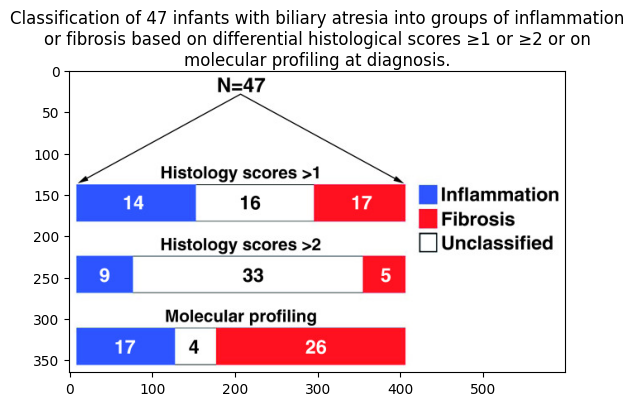

GPT4 answer: There were 17 infants with a differential score of ≥2 for fibrosis.


In [17]:
# Get question
question_id = 20
line = questions[question_id]
idx = line["question_id"]
image_file = line["image"]
qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()

print(f'{idx}: Question: {qs}')

print(f'Image name: {image_file}')
image = Image.open(os.path.join('LLaVA-Med', args_image_folder, image_file))
plt.imshow(image)
plt.title(line["fig_caption"], wrap=True)
plt.show()

answer = line["gpt4_answer"]
print(f'GPT4 answer: {answer}')

In [18]:
model.eval()

LlavaMistralForCausalLM(
  (model): LlavaMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRM

In [19]:
def generate_with_embeddings(model, tokenizer, line, joined_answ=None, max_new_tokens=1024): 
    # get question and image file name
    image_file = line["image"]
    # qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip() # Promt from prepared json
    qs = "What is on the image?" # Universal promt
    qs = qs
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    # get prompt from template and question
    conv = conv_templates[args_conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], 'The image is a')
    prompt = conv.get_prompt()

    # tokenize prompt
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # load image
    image = Image.open(os.path.join('LLaVA-Med/', args_image_folder, image_file))
    image_tensor = process_images([image], image_processor, model.config)[0]

    # Initial sequence of tokens
    inp_len = input_ids.shape[-1]
    
    if joined_answ is not None:
        generated_ids = joined_answ
    else:
        generated_ids = input_ids
    
    all_hidden_states = [] # List for storing embeddings from every layer

    model.eval()

    for _ in range(max_new_tokens):

            # Call forward model to get embeddings and logits
            outputs = model(
                input_ids=generated_ids,
                images=image_tensor.unsqueeze(0).half().cuda(),
                output_hidden_states=True,  # Turn on hidden states return
                output_attentions=True, # Turn on attention maps return
                use_cache=False,
            )
            for i, hidden_state in enumerate(outputs.hidden_states):
                if torch.isnan(hidden_state).any():
                    print(f"NaN detected in layer {i}. Regenerating token...")

            all_hidden_states.append(outputs.hidden_states)

            # Last token's logits
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            
            # Add predicted token to the sequence
            generated_ids = torch.cat([generated_ids, next_token], dim=-1)
            
            torch.cuda.empty_cache()
            # Stop generation, if we got End Of Sequence (EOS) token
            if next_token.item() == tokenizer.eos_token_id:
                break

    # Trasform predicted tokens back to the text
    model_output = generated_ids[..., inp_len:] # take model generated token
    output_text = tokenizer.batch_decode(model_output, skip_special_tokens=True)[0].strip()

    # Clean cache
    clean()

    return input_ids, image_tensor, output_text, all_hidden_states, next_token_logits

### Forward and Backward Hook Calculations

In [23]:
# Predict and run forward hook
joined_answ = None # Provide custom promt
input_ids, _, output_text, all_hidden_states, next_token_logits = generate_with_embeddings(model, tokenizer, line, joined_answ=joined_answ, max_new_tokens=1)


Iside Forward hook for attention layers:
Output tensor shape: torch.Size([1, 599, 4096])
Output tensor shape: torch.Size([1, 32, 599, 599])

Iside Forward hook for mlp with grad:
Output tensor shape: torch.Size([1, 599, 14336])

Iside Forward hook for mlp withput grad:
Output tensor shape: torch.Size([1, 599, 4096])


In [24]:
# Backward hook
loss = next_token_logits[0].sum()

model.zero_grad()
loss.backward()   


Iside Backward hook:
Gradient shape: torch.Size([1, 599, 14336])

Iside Backward hook:
Gradient shape: torch.Size([1, 32, 599, 599])


In [25]:
# Check input sequence and model output
tokenizer.convert_ids_to_tokens(input_ids[0][6:]), output_text

(['▁',
  '<0x0A>',
  'What',
  '▁is',
  '▁on',
  '▁the',
  '▁image',
  '?',
  '▁[',
  '/',
  'INST',
  ']',
  '▁The',
  '▁image',
  '▁is',
  '▁a',
  '▁',
  '</s>'],
 'hist')

In [26]:
def get_image_text_idxs(input_ids, tokenizer, emb_len, img_special_token=IMAGE_TOKEN_INDEX, img_tokens_len=576):
    # define service tokens len
    start_tokens_len = len(tokenizer('[INST]').input_ids)
    end_tokens_len = len(tokenizer('[/INST]').input_ids) - 1
    middle_tokens_len = len(tokenizer('\n').input_ids) - 1
    # get special image toekn position
    img_spec_token_pos = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0]
    assert start_tokens_len == img_spec_token_pos - 1
    # define text tokens indexes in input prompt
    text_tokens_idxs = np.array(range(img_spec_token_pos + middle_tokens_len + 1, len(input_ids[0]))) #  - end_tokens_len
    inps_ids = tokenizer.convert_ids_to_tokens(input_ids[0][text_tokens_idxs])
    print(inps_ids)
    # define image, text tokens indexes
    image_token_idxs = np.arange(start_tokens_len + 1, start_tokens_len + img_tokens_len + 1)
    text_tokens_idxs = text_tokens_idxs + img_tokens_len - 1

    return image_token_idxs, text_tokens_idxs, inps_ids

In [27]:
# Provide recieves embedding lenght
img_emb_idxs, text_emb_idxs, inps_ids = get_image_text_idxs(input_ids, tokenizer, emb_len=599)

['What', '▁is', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']', '▁The', '▁image', '▁is', '▁a', '▁', '</s>']


### MLP Layer Attribution Scores Calculation

In [28]:
# Check shape for mlp layer
stored_attention_grads_mlp.shape, stored_attention_probs_grad.shape # , stored_attention_probs_no_grad.shape

(torch.Size([1, 599, 14336]), torch.Size([1, 599, 14336]))

In [29]:
# Get weights from down_proj and lm_head layer
down_proj_weight = model.model.layers[block_num].mlp.down_proj.state_dict()['weight']
lm_head_weight = model.lm_head.state_dict()['weight']

# Calculate attribution scores
attribution_scores = stored_attention_grads_mlp[:, img_emb_idxs, :] * stored_attention_probs_grad[:, img_emb_idxs, :]
max_corr_values, max_corr_indices = torch.topk(attribution_scores, dim=2, k=10)

# Get maximum attribution score values
interested_values = []
for i in range(attribution_scores.shape[1]):
    interested_values.append(down_proj_weight[:, max_corr_indices.detach().cpu()[0, i]])
interested_values = torch.stack(interested_values)

# Get attribution tokens and decode them into words
attribution_tokens = torch.matmul(interested_values.transpose(1,2), lm_head_weight.unsqueeze(0).transpose(2,1))
attribution_tokens_lbl = torch.argmax(attribution_tokens, dim=2)

attribution_words = []
for i in range(attribution_tokens_lbl.shape[0]):
    attribution_words.append(tokenizer.convert_ids_to_tokens(attribution_tokens_lbl[i]))

In [30]:
# Function to extract words containing '_'
def extract_words_with_symbol(words_list, symbol='▁'):
    extracted_words = []
    for sublist in words_list:
        for word in sublist:
            if symbol in word:
                extracted_words.append(word)
    return extracted_words

# Extract words with the symbol
words_with_symbol = extract_words_with_symbol(attribution_words)

In [31]:
# Compute most frequent words
from collections import Counter
word_counts = Counter(words_with_symbol)

most_frequent_words = word_counts.most_common(10)

In [32]:
most_frequent_words

[('▁/******/', 568),
 ('▁kennis', 516),
 ('▁ingår', 300),
 ('▁indeed', 62),
 ('▁[...]', 53),
 ('▁‘', 42),
 ('▁therefore', 31),
 ('▁ones', 28),
 ('▁Roh', 22),
 ('▁Holl', 21)]

### Sefl-Attention Layer Attention Maps Calculation

In [40]:
# Checl shape for self attention layer
stored_attention_probs_attn_mod.shape, stored_attention_grads_attention.shape

(torch.Size([1, 32, 602, 602]), torch.Size([1, 32, 602, 602]))

In [42]:
# Provide recieves embedding lenght
img_emb_idxs, text_emb_idxs, inps_ids = get_image_text_idxs(input_ids, tokenizer, emb_len=602)

['What', '▁is', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']', '▁The', '▁image', '▁is', '▁a', '▁', '</s>']


In [43]:
# Average attenrions map across attention heads
averaged_attention_grads = torch.max(stored_attention_grads_attention, dim=1)[0]
averaged_attention_probs = torch.max(stored_attention_probs_attn_mod, dim=1)[0]

In [44]:
averaged_attention_grads.shape, averaged_attention_probs.shape

(torch.Size([1, 602, 602]), torch.Size([1, 602, 602]))

In [45]:
text_emb_idxs

array([583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598])

In [46]:
# Get valid attention grads and probs
attention_grads_valid_rows = averaged_attention_grads[:, text_emb_idxs, :].squeeze(0)
attention_probs_valid_rows = averaged_attention_probs[:, text_emb_idxs, :].squeeze(0)

In [47]:
attention_grads_valid_rows.shape, attention_probs_valid_rows.shape

(torch.Size([16, 602]), torch.Size([16, 602]))

In [48]:
# Calculate GradCam
with torch.no_grad():
    
    cams_ = attention_probs_valid_rows[:, img_emb_idxs].reshape(len(text_emb_idxs), 24, 24)
    grads_ = attention_grads_valid_rows[:, img_emb_idxs].reshape(len(text_emb_idxs), 24, 24)
    
    gradcam_ = cams_ * grads_
    print(gradcam_.shape)
    gradcam_ = gradcam_.cpu().detach()

torch.Size([16, 24, 24])


In [49]:
# Function for alaining image and it's gradcam
def getAttMap(img, attMap, blur=True, overlap=True, rgb=False):

    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()

    attMap = cv2.resize(attMap.astype('float32'), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02 * max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()

    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)  # Remove alpha channel
    
    if rgb:
        img = img.reshape(img.shape + (1,))

    if overlap:
        attMap = 1 * (1 - attMap**0.7).reshape(attMap.shape + (1,)) * img + (attMap**0.7).reshape(attMap.shape + (1,)) * attMapV

    return attMap

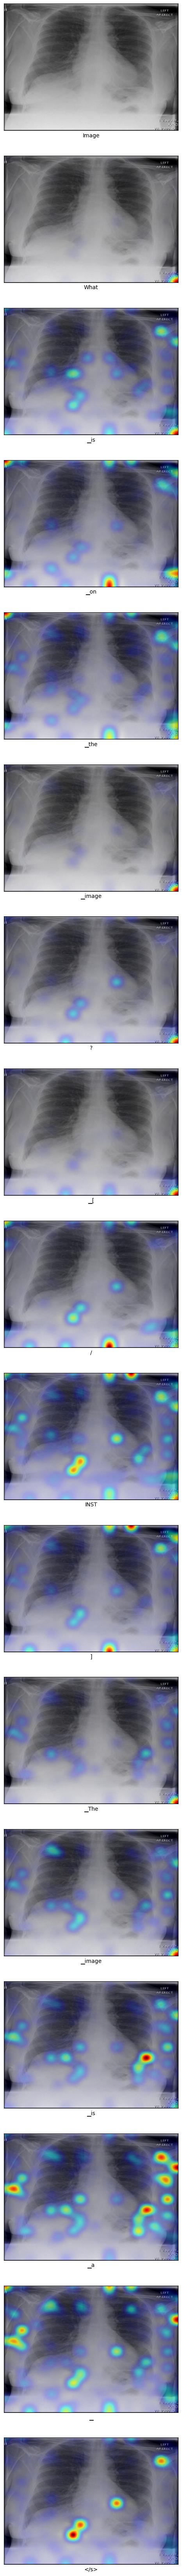

In [50]:
# Visualize
num_image = len(inps_ids) + 1 
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))


rgb_image = Image.open(os.path.join('LLaVA-Med/', args_image_folder, line["image"]))

rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
            
for i, word in enumerate(inps_ids):
    gradcam_image = getAttMap(rgb_image, gradcam_[i].numpy(), rgb=False)
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)